# Hierarchical VQ-VAE

Latent variables are split into $L$ layers. Each layer has a codebook consisting of $K_i$ embedding vectors $\boldsymbol{e}_{i,j}\in R^{D_i}$, $j=1,2,\ldots,K_i$. Posterior categorical distribution of discrete latent variables is
$$
q(k_i|k_{i<},\boldsymbol{x})=\delta_{k_i,k_i^{*}}\,,
$$
where
$$
k_i^{*}=\mathrm{argmin}_{j}\left\Vert q_{\boldsymbol{\phi}}(\boldsymbol{z}_i|\boldsymbol{z}_{i<},\boldsymbol{x})-\boldsymbol{e}_{i,j}\right\Vert _{2}\,.
$$
The Kullback-Leibler divergence is
$$
D_{\mathrm{KL}}\big(q(k_i|k_{i<},\boldsymbol{x})||p_{\boldsymbol{\theta}}(k_i|k_{i<})\big)=
\sum_{k=1}^{K_i}q(k_i|k_{i<},\boldsymbol{x})\log\left(\frac{q(k_i|k_{i<},\boldsymbol{x})}{p_{\boldsymbol{\theta}}(k_i|k_{i<})}\right)=
-\log(p_{\boldsymbol{\theta}}(k_i^{*}|k_{i<}))\,.
$$
We see that Kullback-Leibler divergence is the same as cross-entropy loss for the prior.

## Configuration

Imports

In [1]:
from pathlib import Path
from functools import partial
from collections import defaultdict
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distributions
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vision_utils

Configuration

In [2]:
DATA_DIR = Path("./data")
MODELS_DIR = Path("./models")

NUM_WORKERS = 8
BATCH_SIZE = 64

IMAGE_SIZE = 128
IMAGE_CHANNELS = 3
ENCODER_CHANNELS = 16
LATENT_REDUCTION = 16 # ratio of the number of feature channels to the number of latent channels
NUM_DOWNSAMPLINGS = 5
NUM_EMBEDDINGS = 128

EPOCHS = 10
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-2

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model

In [4]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, act=True):
        padding = (kernel_size - 1) // 2
        layers = [
          nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False),
          nn.BatchNorm2d(out_channels)
        ]
        if act: layers.append(nn.ReLU(inplace=True))
        super().__init__(*layers)
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_normal_(self[0].weight)
        bn = self[1]
        nn.init.ones_(bn.weight)
        nn.init.zeros_(bn.bias)

### VAE Layer

Vector Quantizer

From https://github.com/AntixK/PyTorch-VAE/blob/master/models/vq_vae.py and https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py

In [5]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost = 0.25):
        super().__init__()
        self.commitment_cost = commitment_cost
        self.num_embeddings = num_embeddings
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.reset_parameters()

    def forward(self, latents):
        # Compute L2 distances between latents and embedding weights
        dist = (torch.sum(latents**2, dim=1).unsqueeze(-1) +
                torch.sum(self.embedding.weight**2, dim=1) -
                2 * torch.matmul(latents.movedim(1, -1), self.embedding.weight.T))
        # Alternative implementation:
        # dist = torch.linalg.vector_norm(latents.movedim(1, -1).unsqueeze(-2) - self.embedding.weight, dim=-1)
        encoding_inds = torch.argmin(dist, dim=-1)        # Get the number of the nearest codebook vector
        quantized_latents = self.quantize(encoding_inds)  # Quantize the latents

        # Compute the VQ Losses
        codebook_loss = F.mse_loss(latents.detach(), quantized_latents)
        commitment_loss = F.mse_loss(latents, quantized_latents.detach())
        vq_loss = codebook_loss + self.commitment_cost * commitment_loss
        
        # Make the gradient with respect to latents be equal to the gradient with respect to quantized latents 
        quantized_latents = latents + (quantized_latents - latents).detach()
        return quantized_latents, encoding_inds, vq_loss
    
    def quantize(self, encoding_indices):
        z = self.embedding(encoding_indices)
        z = z.movedim(-1, 1) # Move channels back
        return z
    
    def reset_parameters(self):
        nn.init.uniform_(self.embedding.weight, -1 / self.num_embeddings, 1 / self.num_embeddings)

VAE for skip connections

In [6]:
class VAELayer(nn.Module):
    def __init__(self, channels, latent_reduction, num_embeddings):
        super().__init__()
        latent_channels = channels // latent_reduction
        
        self.to_prior = nn.Sequential(nn.ReLU(inplace=False),
                                      ConvBlock(channels, channels, 3),
                                      nn.Conv2d(channels, num_embeddings, 1))
        self.encoder = ConvBlock(channels, latent_channels, 3, act=False)
        self.vq = VectorQuantizer(num_embeddings, latent_channels)
        self.decoder = ConvBlock(latent_channels, channels, 3)
        self.ce = nn.CrossEntropyLoss(reduction='none')
        
        self.γ = nn.Parameter(torch.zeros(1))
        self.act = nn.ReLU(inplace=True)
    
    def forward(self, x, x_prior):
        logits_prior = self.to_prior(x_prior)
        latents = self.encoder(x)
        
        z, encoding_inds, vq_loss = self.vq(latents)
        kld = self.ce(logits_prior, encoding_inds)
        
        z = self.decoder(z)
        out = z + self.γ * x_prior
        out = self.act(out)
        return out, vq_loss, kld
    
    def sample(self, x_prior, t=1.):
        logits_prior = self.to_prior(x_prior) / t
        dist = distributions.Categorical(logits=logits_prior.movedim(1, -1))
        ind = dist.sample()
        z = self.vq.quantize(ind)
        z = self.decoder(z)
        out = z + self.γ * x_prior
        out = self.act(out)
        return out

### Encoder

In [7]:
class DownBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels, 3)
        )

In [8]:
class Encoder(nn.Module):
    def __init__(self, in_channels, channels, num_downsamplings):
        super().__init__()
        self.stem = ConvBlock(in_channels, channels, 3)
        
        self.blocks = nn.ModuleList()
        in_channels = channels
        for _ in range(num_downsamplings):
            out_channels = in_channels * 2
            self.blocks.append(DownBlock(in_channels, out_channels))
            in_channels = out_channels
    
    def forward(self, x):
        x = self.stem(x)
        
        xs = []
        for block in self.blocks:
            xs.append(x)
            x = block(x)
        return x, xs

### Decoder

In [9]:
class DecoderStem(nn.Module):
    def __init__(self, channels, latent_reduction, num_embeddings, shape):
        super().__init__()
        self.vae = VAELayer(channels, latent_reduction, num_embeddings)
        self.prior = nn.Parameter(torch.full((1, channels, *shape), 0.01))
    
    def forward(self, x):
        out, vq_loss, kld = self.vae(x, self.prior.expand(x.size(0), -1, -1, -1))
        return out, vq_loss, kld
    
    def sample(self, num_samples, t=1.):
        out = self.vae.sample(self.prior.expand(num_samples, -1, -1, -1), t)
        return out

In [10]:
class UpBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.Upsample(scale_factor=2, mode='nearest'),
            ConvBlock(in_channels, out_channels, 3, act=False)
        )

In [11]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, latent_reduction, num_embeddings):
        super().__init__()
        self.up = UpBlock(in_channels, out_channels)
        self.vae = VAELayer(out_channels, latent_reduction, num_embeddings)
    
    def forward(self, x, skip):
        x = self.up(x)
        out, vq_loss, kld = self.vae(skip, x)
        return out, vq_loss, kld
    
    def sample(self, x, t=1.):
        x = self.up(x)
        out = self.vae.sample(x, t)
        return out

In [12]:
class DecoderHead(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            ConvBlock(in_channels, out_channels, 3, act=False),
            nn.Sigmoid()
        )

In [13]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, latent_reduction, num_upsamplings, num_embeddings, shape):
        super().__init__()
        self.stem = DecoderStem(in_channels, latent_reduction, num_embeddings, shape)
        
        self.blocks = nn.ModuleList()
        for _ in range(num_upsamplings):
            channels = in_channels // 2
            self.blocks.append(DecoderBlock(in_channels, channels, latent_reduction, num_embeddings))
            in_channels = channels
        
        self.head = DecoderHead(channels, out_channels)
    
    def forward(self, x, xs):
        vq_losses = []
        klds = []
        x, vql, kld = self.stem(x)
        vq_losses.append(vql)
        klds.append(kld)
        
        for block, skip in zip(self.blocks, reversed(xs)):
            x, vql, kld = block(x, skip)
            vq_losses.append(vql)
            klds.append(kld)
        
        x = self.head(x)
        return x, vq_losses, klds
    
    def sample(self, num_samples, t=1.):
        z  = self.stem.sample(num_samples, t)
        for block in self.blocks:
            z = block.sample(z, t)
        z = self.head(z)
        return z

### Full VAE

In [14]:
class VQVAE(nn.Module):
    def __init__(self, num_downsamplings, latent_reduction, enc_channels, num_embeddings, image_shape, in_channels=3):
        super().__init__()
        reduction = 2**num_downsamplings
        shape = (image_shape[0] // reduction, image_shape[1] // reduction)
        self.encoder = Encoder(in_channels, enc_channels, num_downsamplings)
        self.decoder = Decoder(enc_channels * reduction, in_channels, latent_reduction, num_downsamplings, num_embeddings, shape)

    def forward(self, x):
        x, xs = self.encoder(x)
        out, vq_losses, klds = self.decoder(x, xs)
        return out, vq_losses, klds
    
    def sample(self, num_samples, t=1.):
        with torch.no_grad():
            out = self.decoder.sample(num_samples, t)
        return out

### Model creation

In [15]:
model = VQVAE(num_downsamplings=NUM_DOWNSAMPLINGS, latent_reduction=LATENT_REDUCTION, enc_channels=ENCODER_CHANNELS,
              num_embeddings=NUM_EMBEDDINGS, image_shape=(IMAGE_SIZE, IMAGE_SIZE), in_channels=IMAGE_CHANNELS)

In [16]:
model = model.to(DEVICE)

In [17]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))
print("Number of encoder parameters: {:,}".format(sum(p.numel() for p in model.encoder.parameters())))
print("Number of decoder parameters: {:,}".format(sum(p.numel() for p in model.decoder.parameters())))

Number of parameters: 6,834,826
Number of encoder parameters: 1,573,776
Number of decoder parameters: 5,261,050


## Loss

In [20]:
class VAELoss(nn.Module):
    def __init__(self, λ_vq=1., λ_kld=1.):
        super().__init__()
        self.reconstruction_loss = nn.L1Loss() # nn.MSELoss()
        self.λ_vq = λ_vq
        self.λ_kld = λ_kld
    
    def forward(self, outputs, target):
        output, vq_losses, klds = outputs
        reconst_loss = self.reconstruction_loss(output, target)
        
        total_vq_loss = sum(vq_losses)
        
        kld_losses = [torch.mean(kld) for kld in klds]
        ndims = np.prod(output.shape[1:])
        nlatent = np.array([np.prod(kld.shape[1:]) for kld in klds])
        kld_weights = nlatent / ndims
        total_kld_loss = sum(weight * kld_loss for weight, kld_loss in zip(kld_weights, kld_losses))
        
        loss = reconst_loss + self.λ_vq * total_vq_loss + self.λ_kld * total_kld_loss
        
        loss_dict = {"loss": loss, "reconstruction": reconst_loss}
        for num, (vq_loss, kld_loss) in enumerate(zip(vq_losses, kld_losses)):
            loss_dict[f"VQ{num}"] = vq_loss
            loss_dict[f"KLD{num}"] = kld_loss
        
        return loss_dict

## Utilities

In [21]:
def plot_batch(ax, batch, title=None, **kwargs):
    imgs = vision_utils.make_grid(batch, padding=2, normalize=True)
    imgs = np.moveaxis(imgs.numpy(), 0, -1)
    ax.set_axis_off()
    if title is not None: ax.set_title(title)
    return ax.imshow(imgs, **kwargs)

In [22]:
def show_images(batch, title):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    plot_batch(ax, batch, title)
    plt.show()

In [23]:
def show_2_batches(batch1, batch2, title1, title2):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(121)
    plot_batch(ax, batch1, title1)

    ax = fig.add_subplot(122)
    plot_batch(ax, batch2, title2)
    plt.show()

In [24]:
def reconstruct(model, batch, device):
    batch = batch.to(device)
    with torch.no_grad():
        reconstructed_batch = model(batch)[0]
    reconstructed_batch = reconstructed_batch.cpu()
    return reconstructed_batch

## Data

In [25]:
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [26]:
val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor()
])

In [27]:
train_dset = datasets.CelebA(str(DATA_DIR), split='train', transform=train_transform, download=False)
val_dset = datasets.CelebA(str(DATA_DIR), split='test', transform=val_transform, download=False)

In [28]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS)

val_loader = torch.utils.data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False,
                                         num_workers=NUM_WORKERS)

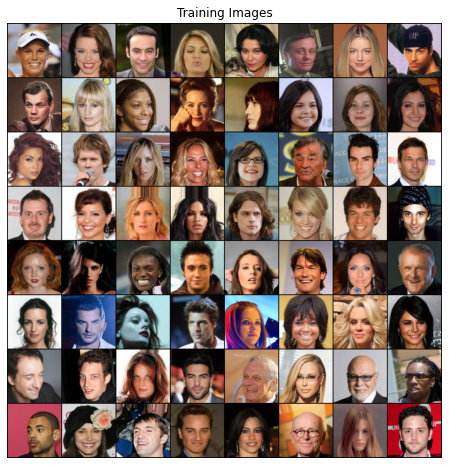

In [29]:
test_batch, _ = next(iter(train_loader))
show_images(test_batch[:64], "Training Images")

## Training

### Learner

In [30]:
class AverageLoss():
    def __init__(self, name):
        self.name = name
        self.reset()
    
    def reset(self):
        self.num_samples = 0
        self.total_loss = 0.
    
    def update(self, data):
        batch_size = data['batch_size']
        self.num_samples += batch_size
        self.total_loss += batch_size * data[self.name]
        
    def compute(self):
        avg_loss = self.total_loss / self.num_samples
        metrics = {self.name: avg_loss}
        return metrics

In [31]:
class Learner:
    def __init__(self, model, loss, optimizer, train_loader, val_loader, device,
                 batch_scheduler=None, epoch_scheduler=None):
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.batch_scheduler = batch_scheduler
        self.epoch_scheduler = epoch_scheduler
        self.history = defaultdict(list)
        
        self.metrics = [AverageLoss(x) for x in ["loss", "reconstruction"]]
        for num in range(NUM_DOWNSAMPLINGS + 1):
            self.metrics.append(AverageLoss(f"VQ{num}"))
            self.metrics.append(AverageLoss(f"KLD{num}"))
    
    def iterate(self, loader, train=False):
        for metric in self.metrics:
            metric.reset()
        
        for batch in loader:
            images = batch[0].to(self.device)
            outputs = self.model(images)
            losses = self.loss(outputs, images)
            
            if train: self.backward_pass(losses["loss"])
            
            data = {k: v.item() for k, v in losses.items()}
            data["batch_size"] = len(images)
            
            for metric in self.metrics:
                metric.update(data)
        
        summary = {}
        for metric in self.metrics:
            summary.update(metric.compute())
        return summary
    
    def backward_pass(self, batch_loss):
        self.optimizer.zero_grad()
        batch_loss.backward()
        self.optimizer.step()

        if self.batch_scheduler is not None:
            self.batch_scheduler.step()
    
    def log_metrics(self, metrics, name):
        print(f"{name}: ", end='', flush=True)
        newline = False
        for key, val in metrics.items():
            self.history[name + ' ' + key].append(val)
            print(f"{key} {val:.4f} ", end='\n' if newline else '')
            newline = not newline
    
    def train(self):
        self.model.train()
        metrics = self.iterate(self.train_loader, train=True)
        self.log_metrics(metrics, 'train')
    
    def validate(self):
        self.model.eval()
        with torch.no_grad():
            metrics = self.iterate(self.val_loader)
        self.log_metrics(metrics, 'val')
    
    def fit(self, epochs):
        for epoch in range(1, epochs + 1):
            print(f"{epoch}/{epochs}:")
            self.train()
            print()
            self.validate()
            print()
            if self.epoch_scheduler is not None:
                self.epoch_scheduler.step()
        
        torch.save(model.state_dict(), str(MODELS_DIR / 'final_model.pt'))

In [32]:
def plot_history_train_val(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history['train ' + key]) + 1)
    ax.plot(xs, history['train ' + key], '.-', label='train')
    ax.plot(xs, history['val ' + key], '.-', label='val')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.grid()
    ax.legend()
    plt.show()

### Start training

In [33]:
loss = VAELoss(λ_kld=1.)

In [34]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [35]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [36]:
learner = Learner(model, loss, optimizer, train_loader, val_loader, DEVICE, batch_scheduler=lr_scheduler)

In [37]:
learner.fit(EPOCHS)

1/10:
train: loss 2.4117 reconstruction 0.0708 
VQ0 0.1906 KLD0 1.3742 
VQ1 0.2228 KLD1 1.8777 
VQ2 0.2260 KLD2 1.8539 
VQ3 0.2435 KLD3 1.6117 
VQ4 0.2054 KLD4 2.3494 
VQ5 0.3219 KLD5 2.0666 

val: loss 1.1344 reconstruction 0.0295 
VQ0 0.0006 KLD0 2.1680 
VQ1 0.0075 KLD1 3.3566 
VQ2 0.0148 KLD2 3.1963 
VQ3 0.0172 KLD3 2.7910 
VQ4 0.0089 KLD4 2.4617 
VQ5 0.0001 KLD5 2.3121 

2/10:
train: loss 1.1344 reconstruction 0.0323 
VQ0 0.0002 KLD0 3.4017 
VQ1 0.0052 KLD1 3.8634 
VQ2 0.0126 KLD2 3.2622 
VQ3 0.0270 KLD3 3.0208 
VQ4 0.0329 KLD4 2.5932 
VQ5 0.0002 KLD5 2.1653 

val: loss 1.1733 reconstruction 0.0458 
VQ0 0.0001 KLD0 3.8078 
VQ1 0.0045 KLD1 3.9697 
VQ2 0.0129 KLD2 3.3749 
VQ3 0.0356 KLD3 3.0983 
VQ4 0.0494 KLD4 2.6788 
VQ5 0.0001 KLD5 2.1396 

3/10:
train: loss 1.1795 reconstruction 0.0306 
VQ0 0.0001 KLD0 3.7786 
VQ1 0.0044 KLD1 3.8532 
VQ2 0.0113 KLD2 3.3692 
VQ3 0.0394 KLD3 3.0674 
VQ4 0.0614 KLD4 2.6834 
VQ5 0.0001 KLD5 2.1630 

val: loss 1.1999 reconstruction 0.0404 
VQ0 0.0000 

### Plotting

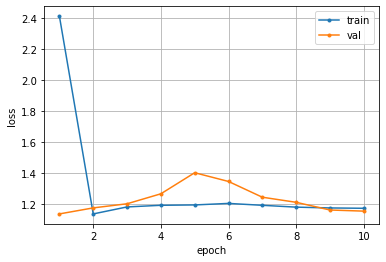

In [38]:
plot_history_train_val(learner.history, 'loss')

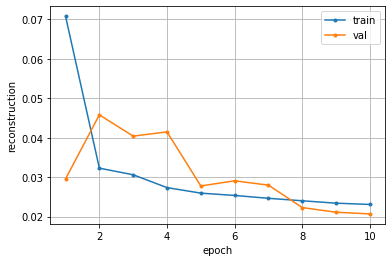

In [39]:
plot_history_train_val(learner.history, 'reconstruction')

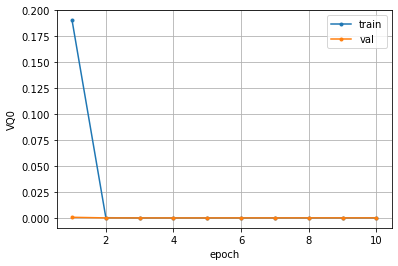

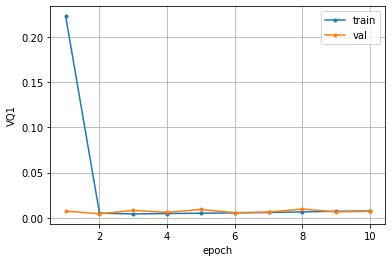

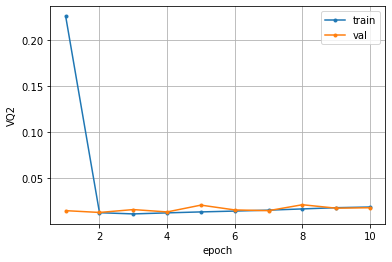

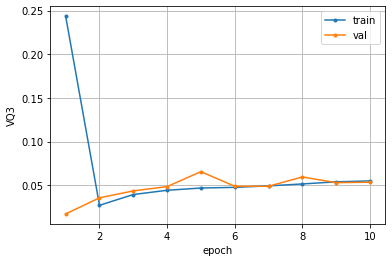

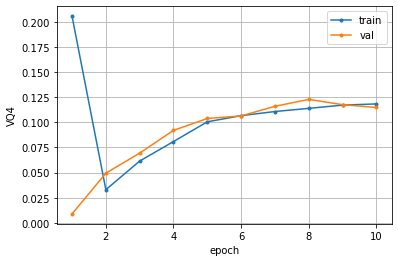

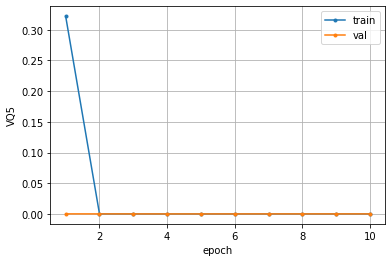

In [40]:
for num in range(NUM_DOWNSAMPLINGS + 1):
    plot_history_train_val(learner.history, f'VQ{num}')

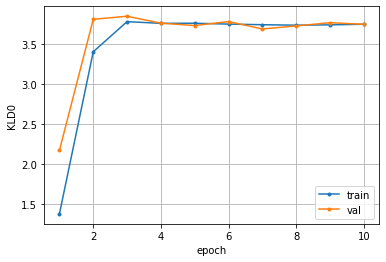

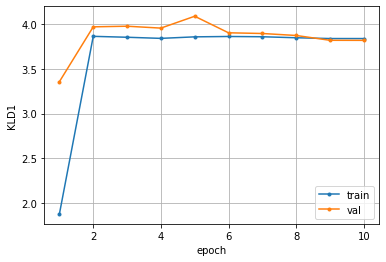

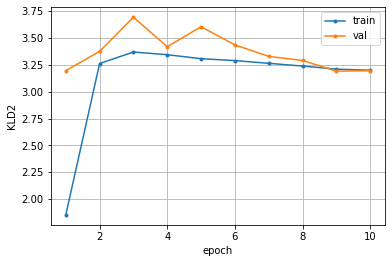

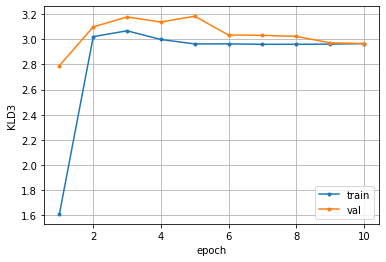

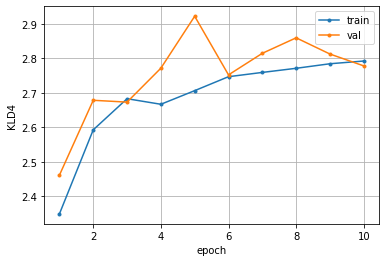

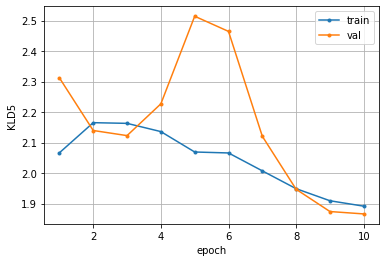

In [41]:
for num in range(NUM_DOWNSAMPLINGS + 1):
    plot_history_train_val(learner.history, f'KLD{num}')

## Testing

In [42]:
model.load_state_dict(torch.load(str(MODELS_DIR / 'final_model.pt')))

<All keys matched successfully>

In [43]:
model.eval();

Testing reconstruction

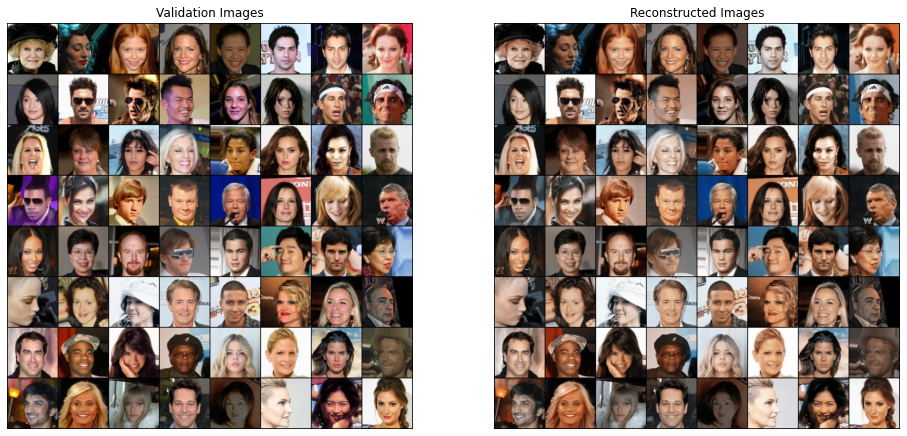

In [44]:
test_batch, _ = next(iter(val_loader))
reconstructed_batch = reconstruct(model, test_batch, DEVICE)
show_2_batches(test_batch[:64], reconstructed_batch[:64], "Validation Images", "Reconstructed Images")

Testing generation

In [69]:
sample_images = model.sample(64, t=0.3)

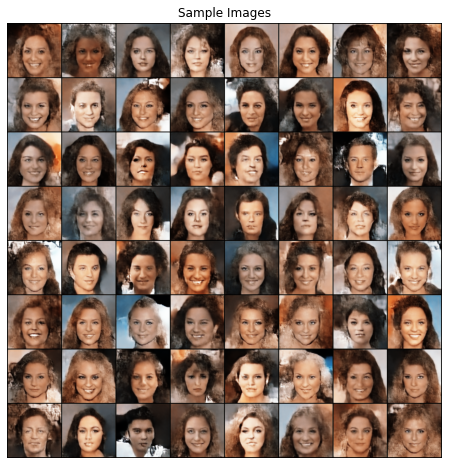

In [70]:
show_images(sample_images.cpu(), "Sample Images")